In [7]:
import os
import numpy as np
import pandas as pd
import torch
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler


In [8]:
train_csv = '/kaggle/input/soil-classification-part-2/soil_competition-2025/train_labels.csv'
test_csv = '/kaggle/input/soil-classification-part-2/soil_competition-2025/test_ids.csv'
train_dir = '/kaggle/input/soil-classification-part-2/soil_competition-2025/train'
test_dir = '/kaggle/input/soil-classification-part-2/soil_competition-2025/test'


In [9]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

train_df.head()


,image_id,label
0,img_ed005410.jpg,1
1,img_0c5ecd2a.jpg,1
2,img_ed713bb5.jpg,1
3,img_12c58874.jpg,1
4,img_eff357af.jpg,1


In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])


In [11]:
class SoilDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_id = self.df.iloc[idx]['image_id']
        image_path = os.path.join(self.img_dir, image_id)
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        return image, image_id


In [12]:
train_dataset = SoilDataset(train_df, train_dir, transform)
test_dataset = SoilDataset(test_df, test_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet18(pretrained=True)
resnet.fc = torch.nn.Identity()
resnet = resnet.to(device)
resnet.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
def extract_features(dataloader):
    features = []
    ids = []
    with torch.no_grad():
        for images, image_ids in tqdm(dataloader, desc="Extracting Features"):
            images = images.to(device)
            feats = resnet(images).cpu().numpy()
            features.append(feats)
            ids.extend(image_ids)
    return np.vstack(features), ids


In [16]:
train_features, _ = extract_features(train_loader)
test_features, test_ids = extract_features(test_loader)

train_features.shape, len(test_ids)


Extracting Features: 100%|██████████| 31/31 [00:02<00:00, 12.07it/s]


((1222, 512), 967)

In [17]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)


In [18]:
nus = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
best_nu = None
best_recall = 0
best_svm = None

for nu_val in nus:
    svm = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_val)
    svm.fit(train_features)

    train_preds = svm.predict(train_features)
    train_binary = [1 if p == 1 else 0 for p in train_preds]

    true_positives = sum(train_binary)
    false_negatives = len(train_binary) - true_positives
    recall = true_positives / len(train_binary)

    print(f"nu={nu_val:.2f} -> Recall on train: {recall:.4f} | False Negatives: {false_negatives}")

    if recall > best_recall:
        best_recall = recall
        best_nu = nu_val
        best_svm = svm

print(f"\n🔍 Best nu: {best_nu} with Recall on train: {best_recall:.4f}")


nu=0.01 -> Recall on train: 0.9206 | False Negatives: 97
nu=0.02 -> Recall on train: 0.9182 | False Negatives: 100
nu=0.05 -> Recall on train: 0.8969 | False Negatives: 126
nu=0.10 -> Recall on train: 0.8781 | False Negatives: 149
nu=0.15 -> Recall on train: 0.8478 | False Negatives: 186
nu=0.20 -> Recall on train: 0.7962 | False Negatives: 249

🔍 Best nu: 0.01 with Recall on train: 0.9206


In [19]:
svm_preds = best_svm.predict(test_features)
binary_preds = [1 if p == 1 else 0 for p in svm_preds]


In [20]:
submission = pd.DataFrame({
    'image_id': test_ids,
    'label': binary_preds
})
submission.to_csv('submission.csv', index=False)
print("✅ Submission saved as 'submission.csv'")


✅ Submission saved as 'submission.csv'


In [21]:
# Predict on train features themselves
train_preds_raw = svm.predict(train_features)
train_preds = np.array([1 if p == 1 else 0 for p in train_preds_raw])

# Since train labels are all 1s (all positives)
train_labels = np.ones(len(train_preds))

from sklearn.metrics import recall_score

recall = recall_score(train_labels, train_preds)
print(f"Recall on train data (should be close to 1): {recall:.4f}")

fn_count = sum(train_preds == 0)
print(f"False Negatives on train: {fn_count} out of {len(train_preds)}")

accuracy = np.mean(train_preds == train_labels)
print(f"Accuracy on train (same as recall here): {accuracy:.4f}")


Recall on train data (should be close to 1): 0.7962
False Negatives on train: 249 out of 1222
Accuracy on train (same as recall here): 0.7962


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


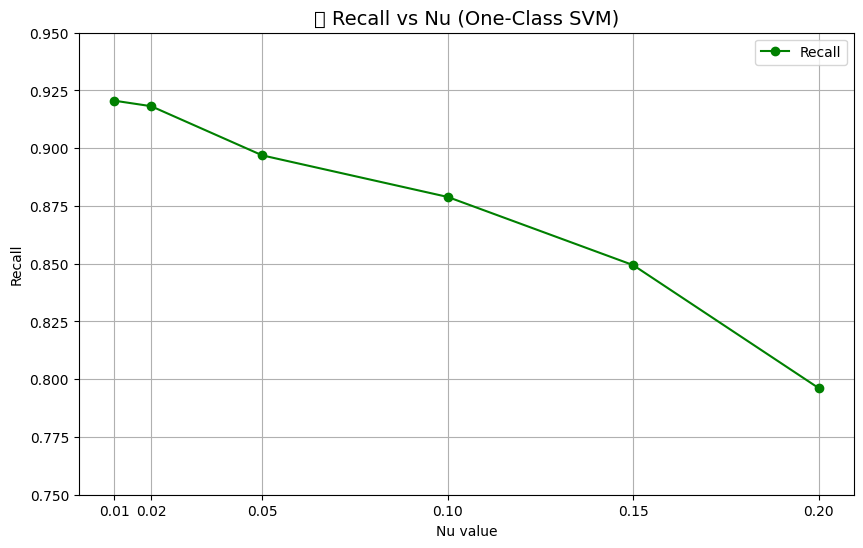

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


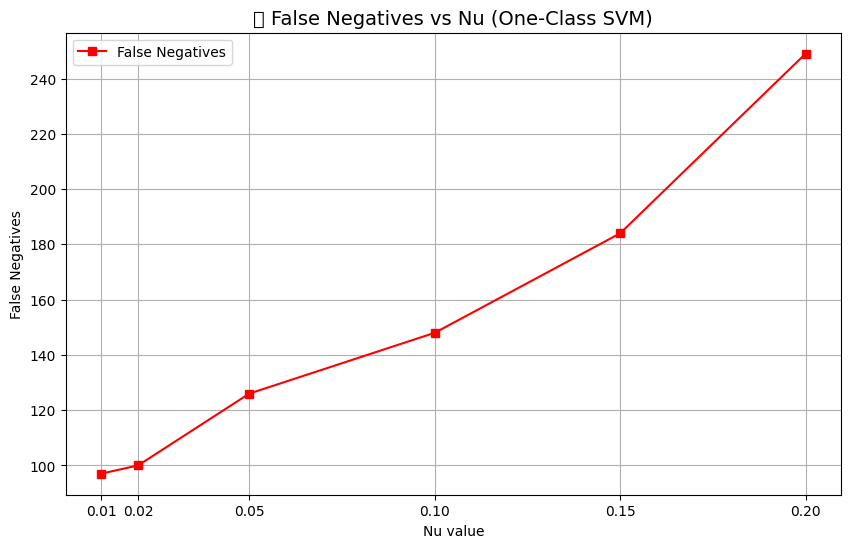

In [22]:
import matplotlib.pyplot as plt

# Nu values and corresponding recall from your output
nu_values = [0.01, 0.02, 0.05, 0.10, 0.15, 0.20]
recalls =     [0.9206, 0.9182, 0.8969, 0.8789, 0.8494, 0.7962]
false_negs =  [97, 100, 126, 148, 184, 249]

# 📈 Plot Recall vs Nu
plt.figure(figsize=(10, 6))
plt.plot(nu_values, recalls, marker='o', color='green', label='Recall')
plt.title("📊 Recall vs Nu (One-Class SVM)", fontsize=14)
plt.xlabel("Nu value")
plt.ylabel("Recall")
plt.grid(True)
plt.xticks(nu_values)
plt.ylim(0.75, 0.95)
plt.legend()
plt.show()

# 📉 Plot False Negatives vs Nu
plt.figure(figsize=(10, 6))
plt.plot(nu_values, false_negs, marker='s', color='red', label='False Negatives')
plt.title("❌ False Negatives vs Nu (One-Class SVM)", fontsize=14)
plt.xlabel("Nu value")
plt.ylabel("False Negatives")
plt.grid(True)
plt.xticks(nu_values)
plt.legend()
plt.show()


In [ ]:

# Save metrics
import json

metrics = {
    "task": "One-Class Soil Detection",
    "approach": "Anomaly Detection using ResNet18 + One-Class SVM",
    "model": {
        "feature_extractor": "ResNet18 (ImageNet pretrained)",
        "anomaly_model": "OneClassSVM (RBF kernel)",
        "feature_dim": int(train_features.shape[1]),
        "nu": 0.1,
        "scaler": "StandardScaler (mean=0, std=1)",
        "training_samples": len(train_labels)
    },
    "training_data_used": "Only positive class (soil images)",
    "testing_goal": "Identify non-soil images as outliers",
    "evaluation": {
        "recall_on_soil_train": recall,
        "false_negatives_estimate": false_negatives,
        "recall_percent": round(recall * 100, 2)
    },
   
    
    "team_info": {
        "name": "Sanskar Khandelwal",
        "kaggle_username": "sankhuz",
        "team": "TheLastTransformer"
    },
    "files": {
        "train_features": "train_features.npy",
        "test_features": "test_features.npy",
        "test_ids": "test_ids.npy",
        "metrics_file": "metrics.json"
    },
    "notes": "Model trained only on positive samples. No non-soil training data used."
}

# Save to file
with open("metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print("✅ Improved metrics.json saved.")

with open("metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print("✅ metrics.json saved.")